In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gausslegendre(N):
    points, weights = np.polynomial.legendre.leggauss(N)
    return points, weights

def gausslobatto(N):
    x = np.zeros(N)
    x[0] = -1.0
    x[-1] = 1.0

    Pn_1 = np.polynomial.legendre.Legendre.basis(N-1)
    dPn_1 = Pn_1.deriv()
    x[1:-1] = np.sort(dPn_1.roots())

    # Compute weights
    w = np.zeros(N)
    for i in range(N):
        xi = x[i]
        Pn_i_val = Pn_1(xi)
        w[i] = 2.0 / (N * (N-1) * (Pn_i_val**2))
    return x, w

In [3]:
def eval_pk(x, i, nodes):
    # Compute the i-th Lagrange basis polynomial at x
    xi = nodes[i]
    terms = [(x - nodes[j])/(xi - nodes[j]) for j in range(len(nodes)) if j != i]
    return np.prod(terms, axis=0)

def eval_pk_deriv(x, i, nodes):
    n = len(nodes)
    xi = nodes[i]
    result = 0.0
    for j in range(n):
        if j == i:
            continue
        xj = nodes[j]
        term = 1.0 / (xi - xj)
        for k in range(n):
            if k == i or k == j:
                continue
            term *= (x - nodes[k]) / (xi - nodes[k])
        result += term
    return result

In [ ]:
# M local
def compute_mass_matrix(sigma_t, a, b, Np):
    """
    Full (consistent) mass matrix on [a,b]:
      Me[m,n] = (b-a)/2 * sum_k w_k * sigma_t(x_k) * l_m(ξ_k)*l_n(ξ_k)
    """
    # interpolation nodes for v_m
    nodes, _ = gausslobatto(Np)
    # quadrature
    xi_q, w_q = gausslegendre(3*Np)
    x_q = 0.5*(b - a)*xi_q + 0.5*(b + a)

    Me = np.zeros((Np, Np))
    for m in range(Np):
        for n in range(Np):
            val = 0.0
            for k in range(3*Np):
                lm = eval_pk(xi_q[k], m, nodes)
                ln = eval_pk(xi_q[k], n, nodes)
                sigma = sigma_t(x_q[k]) if callable(sigma_t) else sigma_t
                val += w_q[k] * sigma * lm * ln
            Me[m, n] = (b - a)/2 * val
    return Me


In [ ]:
# G local
def compute_deriv_matrix(a, b, Np):
    """
    Full (consistent) derivative matrix on [a,b]:
      Ge[m,n] = sum_k w_k * l_m(ξ_k) * l_n'(ξ_k)
    """
    nodes, _ = gausslobatto(Np)
    xi_q, w_q = gausslegendre(3*Np)

    Ge = np.zeros((Np, Np))
    for m in range(Np):
        for n in range(Np):
            val = 0.0
            for k in range(3*Np):
                lm = eval_pk(xi_q[k], m, nodes)
                dp = eval_pk_deriv(xi_q[k], n, nodes)
                val += w_q[k] * lm * dp
            Ge[m, n] = val
    return Ge

In [6]:
# M matrix  
def assemble_mass_matrix(sigma_t, Np, xs):
    Ne = len(xs) - 1
    M = np.zeros((Np*Ne, Np*Ne))
    for je in range(Ne):
        M_local = compute_mass_matrix(sigma_t, xs[je], xs[je+1], Np)
        for n in range(Np):
            for m in range(Np):
                M[je*Np + m, je*Np + n] = M_local[m, n]
    return M

# G matrix
def assemble_deriv_matrix(Np, xs):
    Ne = len(xs) - 1
    G = np.zeros((Np*Ne, Np*Ne))
    for je in range(Ne):
        G_local = compute_deriv_matrix(xs[je], xs[je+1], Np)
        for n in range(Np):
            for m in range(Np):
                G[je*Np + m, je*Np + n] = G_local[m, n]
    return G

In [7]:
def assemble_face_matrices(Np, xs, for_TSA=False):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    M_plus = np.zeros((Np*Ne, Np*Ne))
    M_minus = np.zeros((Np*Ne, Np*Ne))
    pk0 = np.zeros(Np)
    pk1 = np.zeros(Np)
    
    for n in range(Np):
        pk0[n] = eval_pk(-1.0, n, mus)
        pk1[n] = eval_pk(1.0, n, mus)
    
    # Interior faces
    for je in range(1, Ne-1):
        for n in range(Np):
            for m in range(Np):
                M_plus[je*Np + m, je*Np + n] = pk1[m] * pk1[n]
                M_plus[je*Np + m, (je-1)*Np + n] = -pk0[m] * pk1[n]
                M_minus[je*Np + m, (je+1)*Np + n] = pk1[m] * pk0[n]
                M_minus[je*Np + m, je*Np + n] = -pk0[m] * pk0[n]
    
    # Left boundary
    je = 0
    for n in range(Np):
        for m in range(Np):
            M_plus[je*Np + m, je*Np + n] = pk1[m] * pk1[n]
            if for_TSA:
                M_plus[je*Np + m, je*Np + n] -= pk0[m] * pk0[n]
            M_minus[je*Np + m, (je+1)*Np + n] = pk1[m] * pk0[n]
            M_minus[je*Np + m, je*Np + n] = -pk0[m] * pk0[n]
    
    # Right boundary
    je = Ne-1
    for n in range(Np):
        for m in range(Np):
            M_plus[je*Np + m, je*Np + n] = pk1[m] * pk1[n]
            M_plus[je*Np + m, (je-1)*Np + n] = -pk0[m] * pk1[n]
            M_minus[je*Np + m, je*Np + n] = -pk0[m] * pk0[n]
            if for_TSA:
                M_minus[je*Np + m, je*Np + n] += pk1[m] * pk1[n]
    
    return M_plus, M_minus


In [8]:
def compute_inflow_term_plus(inflow, Np, xs):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    qs = np.zeros(Ne*Np)
    je = 0
    for m in range(Np):
        qs[je*Np + m] = inflow(xs[0]) * eval_pk(-1.0, m, mus)
    return qs

def compute_inflow_term_minus(inflow, Np, xs):
    Ne = len(xs) - 1
    mus, ws = gausslobatto(Np)
    qs = np.zeros(Ne*Np)
    je = Ne-1
    for m in range(Np):
        qs[je*Np + m] = inflow(xs[-1]) * eval_pk(1.0, m, mus)
    return qs


In [9]:
def compute_source_term(source, Np, xs):
    Ne = len(xs) - 1
    s, ws = gausslobatto(Np)  # Interpolation points and weights
    s2, ws2 = gausslegendre(3*Np)  # For integration
    qs = np.zeros(Ne * Np)
    for je in range(Ne):
        a = xs[je]
        b = xs[je + 1]
        for m in range(Np):
            val = 0.0
            for k in range(len(s2)):
                x = s2[k]
                # Map from reference [-1,1] to [a,b]
                y = b * (x + 1) / 2 + a * (1 - x) / 2
                val += ws2[k] * eval_pk(x, m, s) * source(y)
            qs[je * Np + m] = (b - a) / 2.0 * val
    return qs


In [15]:
def transport_direct_solve_plus(mu, sigma_t, qs, inflow, Np, xs):
    Ne = len(xs) - 1 # Number of elements
    mus, ws = gausslobatto(Np)
    qs_inflow = compute_inflow_term_plus(inflow, Np, xs)
    F_plus, F_minus = assemble_face_matrices(Np, xs)
    G = assemble_deriv_matrix(Np, xs)
    M = assemble_mass_matrix(sigma_t, Np, xs)
    A = -mu * G + mu * F_plus + M
    qs += mu * qs_inflow
    psi = np.linalg.solve(A, qs)
    return psi

def transport_direct_solve_minus(mu, sigma_t, qs, inflow, Np, xs):
    Ne = len(xs) - 1 # Number of elements
    mus, ws = gausslobatto(Np)
    qs_inflow = compute_inflow_term_minus(inflow, Np, xs)
    F_plus, F_minus = assemble_face_matrices(Np, xs)
    G = assemble_deriv_matrix(Np, xs)
    M = assemble_mass_matrix(sigma_t, Np, xs)
    A = -mu * G + mu * F_minus + M
    qs -= mu * qs_inflow
    psi = np.linalg.solve(A, qs)
    return psi

def transport_direct_solve(mu, sigma_t, qs, inflow, Np, xs):
    if mu > 0:
        psi = transport_direct_solve_plus(mu, sigma_t, qs, inflow, Np, xs)
    else:
        psi = transport_direct_solve_minus(abs(mu), sigma_t, qs, inflow, Np, xs)
    return psi


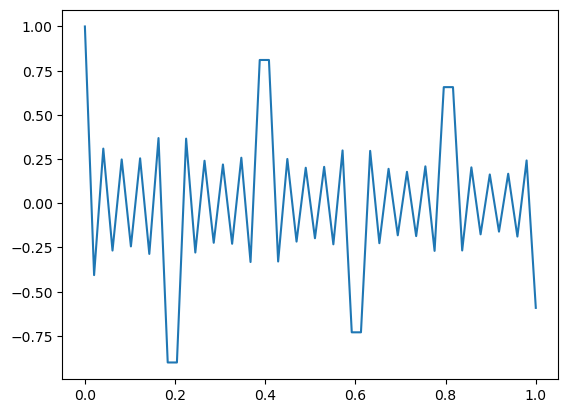

In [19]:
mu = .1
Np = 10
Ne = 5
a = 0
b = 1
xs = np.linspace(a,b,Ne+1)

def source(x):
    return 0

def inflow(x):
    return 1

def sigma_t(x):
    return 1

qs = compute_source_term(source, Np, xs)

psi = transport_direct_solve(mu,sigma_t,qs,inflow,Np,xs)

x = np.linspace(a,b, len(psi))
plt.plot(x, psi)
plt.show()

In [13]:
def plot_solution(psi, xs, Np, mu=None, num_plot_pts=200):
    """
    Reconstructs and plots the DG solution psi(x) over the mesh xs.
    """
    mus, _ = gausslobatto(Np)
    xi_plot = np.linspace(-1, 1, num_plot_pts)
    # print(psi)

    plt.figure()
    for je in range(len(xs)-1):
        a, b = xs[je], xs[je+1]
        psi_loc = psi[je*Np:(je+1)*Np]

        # map reference -> physical
        x_phys = 0.5*(b - a)*(xi_plot + 1) + 0.5*(b + a)

        # reconstruct polynomial on this element
        psi_plot = np.zeros_like(xi_plot)
        for n in range(Np):
            psi_plot += psi_loc[n] * eval_pk(xi_plot, n, mus)

        plt.plot(x_phys, psi_plot, '-')

    plt.xlabel('x')
    plt.ylabel(r'$\psi(x)$')
    if mu is not None:
        plt.title(f'DG solution, μ = {mu}')
    plt.grid(True)
    plt.show()

In [22]:
psi.shape

(50,)

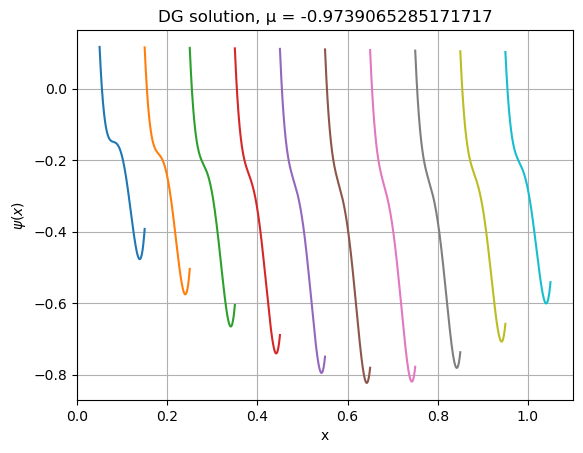

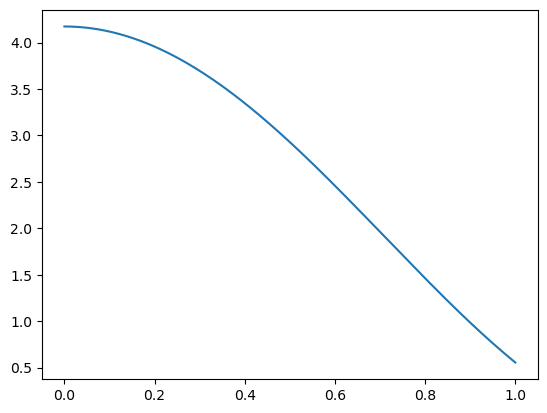

In [43]:
# ─── Example usage ──────────────────────────────
if __name__ == "__main__":
    colloc_nodes,_ = gausslegendre(2*Np) 
    mu      = colloc_nodes[0]
    sigma_t = lambda x: x**2 + 1            # constant total cross section
    inflow  = lambda x: 0.1             # unit inflow at left
    source  = lambda x: (mu**3)*(2*x - 6.8*np.sin(2*x)) + (sigma_t(x) * (mu**2)*((x**2 +1) + 3.4*np.cos(2*x)))
    xs      = np.linspace(0, 1, 11)       # 10 elements on [0,1]
    Np      = 5                         # 4 GLL nodes per element
    qs      = compute_source_term(source, Np, xs)  # zero volumetric source

    x1 = np.linspace(0,1,200)
    psi1 = lambda x: (mu**2)*((x**2 +1) + 3.4*np.cos(2*x))
    y1 = [psi1(xi) for xi in x1]

    psi = transport_direct_solve(mu, sigma_t, qs, inflow, Np, xs)
    plot_solution(psi, xs, Np, mu=mu)
    plt.plot(x1,y1)
    